<a href="https://colab.research.google.com/github/HelenLit/lanigans-ball_generating-text/blob/main/lanigans-ball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Text with Neural Networks

In the previous commit, I trained a model on just a single song. I have found that the output text can quickly become gibberish or repetitive. Even if I tweak the hyperparameters, the model will still be limited by its vocabulary of only 263 words. The model will be more flexible if I train it on a much larger corpus and that's what I'll be doing in this lab. I will use lyrics from more Irish songs then see how the generated text looks like. I will also see how this impacts the process from data preparation to model training.

## Imports

First, I import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Building the Word Vocabulary

In [2]:
# Download the dataset
!gdown --id 15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT
To: /content/irish-lyrics-eof.txt
100% 69.0k/69.0k [00:00<00:00, 93.9MB/s]


I lowercase and split the plain text into a list of sentences:

In [4]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
#print(corpus)

Then, I use the `Tokenizer` class to build the word index dictionary.

In [5]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'thro

## Preprocessing the Dataset

Next, I generate the training sequences and their labels. I take each line of the song and generate inputs and labels from it. For example, if I only have one sentence: "I am using Tensorflow", I want the model to learn the next word given any subphrase of this sentence:

```
INPUT              LABEL
-----------------------------
I             ---> am
I am          ---> using
I am using    ---> Tensorflow
```

The next cell shows how to implement this concept in code. The result would be inputs as padded sequences, and labels as one-hot encoded arrays.

In [6]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

The result for the first line of the song. The particular line and the expected token sequence is shown in the cell below:

In [7]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


Since there are 8 tokens here, I can expect to find this particular line in the first 7 elements of the `xs` that I generated earlier. If we get the longest subphrase generated, that should be found in `xs[6]`. The padded token sequence below:

In [9]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')


token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']


If we print out the label, it should show `70` because that is the next word in the phrase (i.e. `lanigan`). The one-hot encoded form is below. I use [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method to get the index of the 'hot' label.

In [10]:
# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


If we pick the element before that, we will see the same subphrase as above minus one word:

In [12]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48]
decoded to text: ['come all ye maidens young']
one-hot label: [0. 0. 1. ... 0. 0. 0.]
index of label: 2


## Build the Model

Next, I build the model with basically the same layers as before. The main difference is you will remove the sigmoid output and use a softmax activated `Dense` layer instead. This output layer will have one neuron for each word in the vocabulary. So given an input token list, the output array of the final layer will have the probabilities for each word.

In [13]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1379890 (5.26 MB)
Trainable params: 1379890 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Defining the callback

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.9:
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

## Train the model

I can now train the model. I have a relatively small vocabulary so it will only take a couple of minutes to complete 500 epochs.

In [16]:
epochs = 100

callbacks = myCallback()

# Train the model
history = model.fit(xs, ys, epochs=epochs, callbacks=callbacks)

Epoch 1/100
377/377 [==============================] - 29s 78ms/step - loss: 4.5989 - accuracy: 0.1976
Epoch 2/100
377/377 [==============================] - 29s 77ms/step - loss: 3.6521 - accuracy: 0.2727
Epoch 3/100
377/377 [==============================] - 29s 77ms/step - loss: 2.8472 - accuracy: 0.3799
Epoch 4/100
377/377 [==============================] - 31s 83ms/step - loss: 2.2651 - accuracy: 0.4809
Epoch 5/100
377/377 [==============================] - 30s 78ms/step - loss: 1.8319 - accuracy: 0.5707
Epoch 6/100
377/377 [==============================] - 29s 78ms/step - loss: 1.5230 - accuracy: 0.6376
Epoch 7/100
377/377 [==============================] - 32s 84ms/step - loss: 1.2856 - accuracy: 0.6952
Epoch 8/100
377/377 [==============================] - 33s 87ms/step - loss: 1.1182 - accuracy: 0.7317
Epoch 9/100
377/377 [==============================] - 31s 82ms/step - loss: 1.0653 - accuracy: 0.7448
Epoch 10/100
377/377 [==============================] - 31s 81ms/step - l

Then, I visualize the results with the utility below.

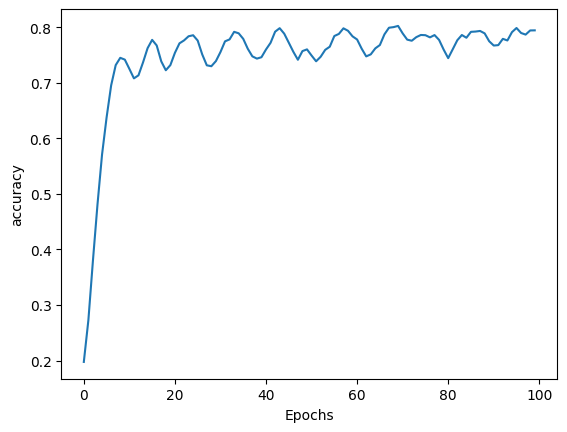

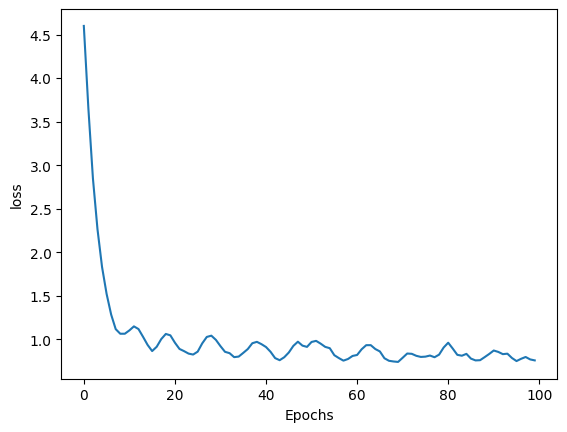

In [19]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')
# Visualize the loss
plot_graphs(history, 'loss')

## Generating Text

With the model trained, I can now use it to make its own song! The process would look like:

1. Feed a seed text to initiate the process.
2. Model predicts the index of the most probable next word.
3. Look up the index in the reverse word index dictionary
4. Append the next word to the seed text.
5. Feed the result to the model again.

Steps 2 to 5 will repeat until the desired length of the song is reached. It is implemented in the code below:

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 24ms/step
Laurence went to Dublin the room and dancing i might ask youll eyes glisten glisten glisten glisten glisten water weeks up up up in jig jig entangled entangled entangled suppose them them entangled three weeks up up up at entangled entangled entangled entangled give me and them them all couples and groups groups relations relations all hall entangled the colleen forget ask forget put had glisten glisten glisten glisten painted weeks up up up up a jig jig strangled might hall jig jig jig might ask youll glisten glisten glisten ask ask glisten glisten glisten entangled odaly me mavrone me me mavrone me at


In the output above, I notice frequent repetition of words the longer the sentence gets. There are ways to get around it and the next cell shows one. Basically, instead of getting the index with max probability, I should get the top three indices and choose one at random. The output text makes more sense with this approach. This is not the most time efficient solution because it is always sorting the entire array even if we only need the top three.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

		# Look up the word associated with the index.
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result
print(seed_text)

1/1 [==============================] - 0s 25ms/step
Laurence went to Dublin the room got as a able ask forget ask replied weeks a of relations entangled runctions at all entangled strangled odaly mavrone me me mavrone mavrone me mavrone weeks at them me were hearty ask ask hearty died jig again at me mavrone mavrone me nelly daughter entangled me entangled me me entangled til eyes entangled relations nonsensical polkas ask polkas ask youll glisten glisten ask youll weeks ask glisten youll glisten youll eyes glisten mchugh weeks at entangled three weeks up up mavrone me mavrone me me mavrone and might call able rose dolans hall hall glisten glisten strangled


## Wrap Up

In this project, I got a first look at preparing data and building a model for text generation. The corpus is fairly small in this particular exercise and in the next projects, I will be building one from a larger body of text.